# Models exploration
Compare YOLO and Faster R-CNN experiments. This notebook mirrors training_exploration.ipynb with both backends.

# Models exploration (YOLO vs Faster R-CNN)
Compare two backends with shared dataset/config plumbing.


In [19]:
%matplotlib inline
from pathlib import Path
import sys
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Normalize project root
PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    
from src.predictors import get_detector
from src.config import Paths, TrainingConfig, TorchvisionDetectionConfig
from src import data as data_utils

# Dataset (YOLO format). Swap root to try another dataset.
DATASET_ROOT = PROJECT_ROOT / "Poles2025/Road_poles_iPhone"
# DATASET_ROOT = PROJECT_ROOT / "Poles2025/roadpoles_v1"
paths = Paths(dataset_root=DATASET_ROOT)

# Inference / matching controls
CONF_THRESH = 0.25
IOU_MATCH = 0.5
OVERLAP_IOU_THRESH = 0.3
MAX_EVAL_IMAGES = 400000
DATASET_ROOT


PosixPath('/home/erikhbj/Documents/tdt17/TDT17-snow-pole-detection/Poles2025/Road_poles_iPhone')

In [ ]:
# Define experiments across backends
experiments = [
    {"name": "yolov11s_baseline", "backend": "yolo", "train_cfg": {"model": "yolo11s.pt", "epochs": 3, "batch": 8, "imgsz": 640}},
    {"name": "fasterrcnn_r50", "backend": "fasterrcnn", "train_cfg": {"epochs": 3, "batch_size": 2, "lr": 0.005}},
]
experiments

[{'name': 'yolov8n_baseline',
  'backend': 'yolo',
  'train_cfg': {'model': 'yolov8n.pt', 'epochs': 3, 'batch': 8, 'imgsz': 640}},
 {'name': 'yolov8s_baseline',
  'backend': 'yolo',
  'train_cfg': {'model': 'yolov8s.pt', 'epochs': 3, 'batch': 8, 'imgsz': 640}},
 {'name': 'fasterrcnn_r50',
  'backend': 'fasterrcnn',
  'train_cfg': {'epochs': 3, 'batch_size': 2, 'lr': 0.005}}]

In [21]:
# Helper functions
def metrics_from_results(metrics_obj):
    res = getattr(metrics_obj, "results_dict", {}) or {}
    return {
        "precision": res.get("metrics/precision(B)"),
        "recall": res.get("metrics/recall(B)"),
        "map50": res.get("metrics/mAP50(B)"),
        "map5095": res.get("metrics/mAP50-95(B)"),
        "val_loss": res.get("val_loss"),
    }

def xywh_to_xyxy(xywh):
    cx, cy, w, h = xywh
    return np.array([cx - w/2, cy - h/2, cx + w/2, cy + h/2])

def iou(box1, box2):
    xa, ya = max(box1[0], box2[0]), max(box1[1], box2[1])
    xb, yb = min(box1[2], box2[2]), min(box1[3], box2[3])
    inter = max(0, xb - xa) * max(0, yb - ya)
    area1 = max(0, box1[2]-box1[0]) * max(0, box1[3]-box1[1])
    area2 = max(0, box2[2]-box2[0]) * max(0, box2[3]-box2[1])
    union = area1 + area2 - inter + 1e-9
    return inter / union


In [22]:
# Train and evaluate all experiments
results_rows = []
for exp in experiments:
    backend = exp["backend"]
    print(f"=== Training {exp['name']} ({backend}) ===")

    if backend == "yolo":
        cfg = TrainingConfig(**exp["train_cfg"])
        overrides = {"name": exp["name"]}
        eval_kwargs = {"imgsz": cfg.imgsz, "batch": cfg.batch, "conf": CONF_THRESH}
    else:
        cfg = TorchvisionDetectionConfig(**exp["train_cfg"])
        overrides = None
        eval_kwargs = {}

    detector = get_detector(backend, paths=paths, train_cfg=cfg, overrides=overrides)
    train_res = detector.train()
    weights_path = exp.get("weights_override") or train_res.last_checkpoint
    if weights_path is None:
        raise RuntimeError("No weights produced for experiment" )

    metrics = detector.evaluate(weights=Path(weights_path), **eval_kwargs)
    m = metrics_from_results(metrics)

    results_rows.append({
        "name": exp["name"],
        "backend": backend,
        "train_time_s": getattr(train_res, "train_time_seconds", None),
        "eval_time_s": getattr(metrics, "eval_time_seconds", None),
        "weights": str(weights_path),
        **m,
    })

results_df = pd.DataFrame(results_rows)
display(results_df.sort_values(["map50", "val_loss"], ascending=[False, True]))


=== Training yolov8n_baseline (yolo) ===
New https://pypi.org/project/ultralytics/8.3.231 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.230 🚀 Python-3.13.5 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24208MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/erikhbj/Documents/tdt17/TDT17-snow-pole-detection/Poles2025/artifacts/data_resolved.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0,

,name,backend,train_time_s,eval_time_s,weights,precision,recall,map50,map5095,val_loss
2,fasterrcnn_r50,fasterrcnn,169.835497,19.417791,runs/fasterrcnn_last.pth,0.695560,0.996970,0.982548,0.724105,0.061873
1,yolov8s_baseline,yolo,18.231570,2.541767,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.801631,0.736364,0.814570,0.533660,NaN
0,yolov8n_baseline,yolo,16.286227,2.514802,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.825784,0.718182,0.804630,0.537701,NaN


## Aggregate metrics plots
Quick comparison of precision/recall/mAP and time (val loss shown when available).


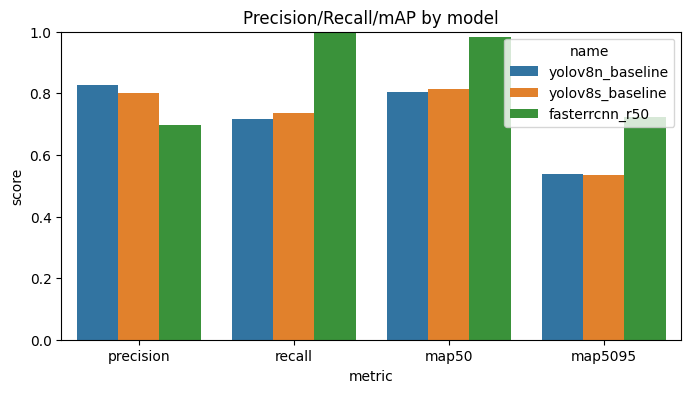

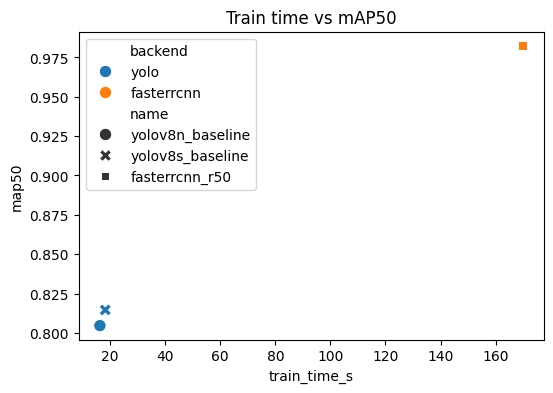

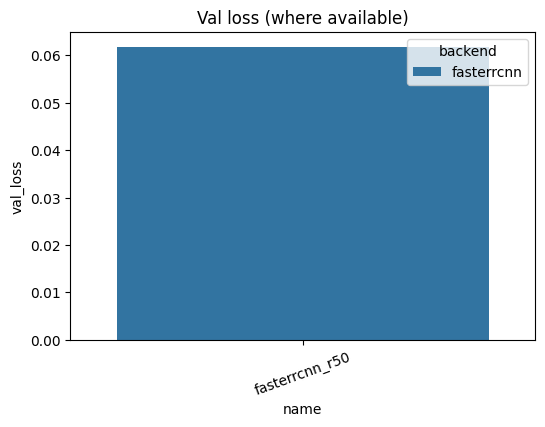

In [23]:
plot_df = results_df.melt(id_vars=['name','backend'], value_vars=['precision','recall','map50','map5095'], var_name='metric', value_name='score')
plot_df = plot_df.dropna(subset=['score'])
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=plot_df, x='metric', y='score', hue='name', ax=ax)
ax.set_title('Precision/Recall/mAP by model')
ax.set_ylim(0, 1)
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=results_df, x='train_time_s', y='map50', hue='backend', style='name', s=80, ax=ax)
ax.set_title('Train time vs mAP50')
plt.show()

if results_df['val_loss'].notna().any():
    fig, ax = plt.subplots(figsize=(6,4))
    sns.barplot(data=results_df.dropna(subset=['val_loss']), x='name', y='val_loss', hue='backend', ax=ax)
    ax.set_title('Val loss (where available)')
    plt.xticks(rotation=20)
    plt.show()


## Per-prediction analysis (best YOLO model)
If no YOLO run with mAP exists, this section will be skipped.
Note: Road_poles_iPhone uses filelists (Train.txt/Validation.txt), not split folders; we load val via filelist below.


In [24]:
from ultralytics import YOLO
from src.data import load_annotations_from_filelist

map_rows = results_df.dropna(subset=['map50'])
map_rows = map_rows[map_rows['backend'] == 'yolo']
if map_rows.empty:
    print('No YOLO results with mAP available; skipping per-prediction analysis.')
    pred_df = pd.DataFrame()
    sample_imgs = []
    pred_results = []
else:
    best_row = map_rows.sort_values('map50', ascending=False).iloc[0]
    weights_path = Path(best_row['weights'])
    print(f'Using YOLO weights: {weights_path}')
    model = YOLO(weights_path)

    # Load val annotations via filelist (Validation.txt)
    val_df = load_annotations_from_filelist(paths.dataset_root / 'Validation.txt', paths.dataset_root, images_dirname='images', labels_dirname='labels')
    val_images = val_df['image_path'].dropna().unique().tolist()
    print(f'Validation images: {len(val_images)}')

    sample_imgs = val_images[: min(len(val_images), MAX_EVAL_IMAGES)]
    pred_results = model(sample_imgs, conf=CONF_THRESH, verbose=False)

    records = []
    for img_path, pred in zip(sample_imgs, pred_results):
        gt_rows = val_df[val_df['image_path'] == Path(img_path)]
        gt_boxes = [xywh_to_xyxy((r.cx, r.cy, r.w, r.h)) for r in gt_rows.itertuples()]
        if pred.boxes is None:
            continue
        pred_xywhn = pred.boxes.xywhn.cpu().numpy()
        pred_conf = pred.boxes.conf.cpu().numpy()
        pred_cls = pred.boxes.cls.cpu().numpy()
        for xywhn, conf, cls in zip(pred_xywhn, pred_conf, pred_cls):
            if conf < CONF_THRESH:
                continue
            best_iou = 0.0
            hit = False
            for gt_box in gt_boxes:
                i = iou(xywh_to_xyxy(xywhn), gt_box)
                if i > best_iou:
                    best_iou = i
                if i >= IOU_MATCH:
                    hit = True
            records.append({
                'image_path': str(img_path),
                'cx': xywhn[0],
                'cy': xywhn[1],
                'w': xywhn[2],
                'h': xywhn[3],
                'conf': conf,
                'cls': int(cls),
                'hit': hit,
                'best_iou': best_iou,
            })
    pred_df = pd.DataFrame(records)

pred_df.head()


Using YOLO weights: /home/erikhbj/Documents/tdt17/TDT17-snow-pole-detection/notebooks/runs/yolov8s_baseline27/weights/best.pt
Validation images: 261


,image_path,cx,cy,w,h,conf,cls,hit,best_iou
0,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.966418,0.498013,0.026442,0.118051,0.711015,0,True,0.858303
1,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.961511,0.498724,0.022565,0.124521,0.297049,0,True,0.647212
2,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.905658,0.505920,0.018133,0.100673,0.729279,0,True,0.822881
3,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.059963,0.503032,0.022113,0.030634,0.471246,0,False,0.000000
4,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.840382,0.496125,0.024602,0.055515,0.706793,0,True,0.839615


In [25]:
if pred_df.empty:
    print('No prediction data to process.')
else:
    print('Collected', len(pred_df), 'predictions across', pred_df['image_path'].nunique(), 'images.')
    pred_df.head()


Collected 324 predictions across 227 images.


,hit,count,mean
0,False,32,0.383561
1,True,292,0.579159


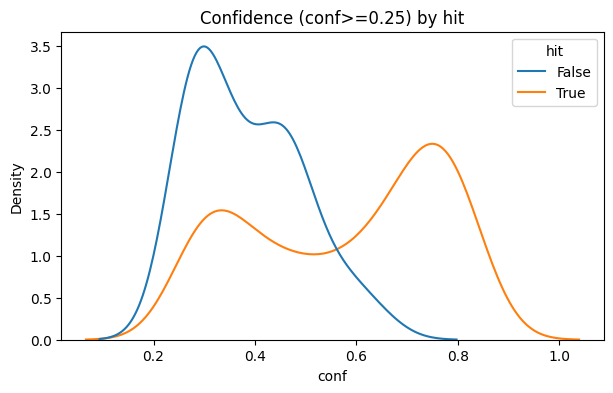

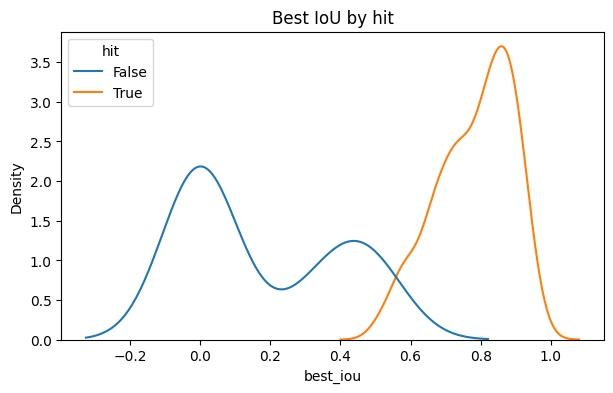

In [26]:
if pred_df.empty:
    print('No prediction data to summarize.')
else:
    summary = pred_df.groupby('hit')['conf'].agg(['count','mean']).reset_index()
    display(summary)

    fig, ax = plt.subplots(figsize=(7,4))
    sns.kdeplot(data=pred_df, x='conf', hue='hit', common_norm=False, ax=ax)
    ax.set_title(f'Confidence (conf>={CONF_THRESH}) by hit')
    plt.show()

    fig, ax = plt.subplots(figsize=(7,4))
    sns.kdeplot(data=pred_df, x='best_iou', hue='hit', common_norm=False, ax=ax)
    ax.set_title('Best IoU by hit')
    plt.show()


### Visualize one TP and one FP (confidence shaded)


In [27]:
if pred_df.empty:
    print('No predictions to visualize.')
else:
    def visualize_prediction(img_path, pred, title, edgecolor='cyan'):
        img = plt.imread(img_path)
        h, w = img.shape[:2]
        fig, ax = plt.subplots(figsize=(8,6))
        ax.imshow(img)
        if pred.boxes is not None:
            xywhn = pred.boxes.xywhn.cpu().numpy()
            confs = pred.boxes.conf.cpu().numpy()
            for (cx, cy, bw, bh), c in zip(xywhn, confs):
                cx_px, cy_px = cx * w, cy * h
                bw_px, bh_px = bw * w, bh * h
                rect = plt.Rectangle((cx_px - bw_px/2, cy_px - bh_px/2), bw_px, bh_px, fill=False, edgecolor=edgecolor, linewidth=2, alpha=0.8)
                ax.add_patch(rect)
                ax.text(cx_px, cy_px, f'{c:.2f}', color='yellow', fontsize=10)
        ax.set_title(title)
        plt.axis('off')
        plt.show()


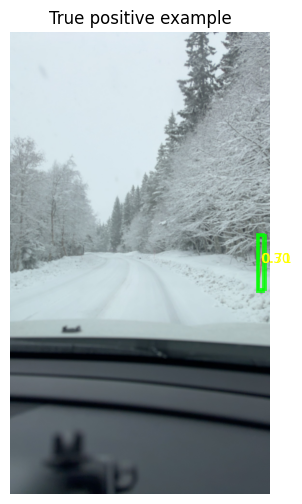

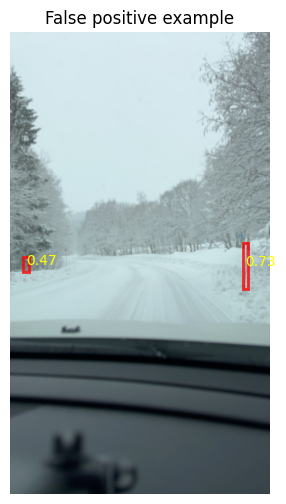

In [28]:
if pred_df.empty:
    print('No FP/TP examples to visualize.')
else:
    tp_pred = fp_pred = None
    tp_img = fp_img = None
    for img_path, pred in zip(sample_imgs, pred_results):
        if pred.boxes is None:
            continue
        xywhn = pred.boxes.xywhn.cpu().numpy()
        confs = pred.boxes.conf.cpu().numpy()
        for (cx, cy, bw, bh), c in zip(xywhn, confs):
            if c < CONF_THRESH:
                continue
            row = pred_df[(pred_df['image_path'] == str(img_path)) & (pred_df['cx'] == cx) & (pred_df['cy'] == cy) & (pred_df['w'] == bw) & (pred_df['h'] == bh)]
            if row.empty:
                continue
            hit = bool(row.iloc[0]['hit'])
            if hit and tp_pred is None:
                tp_pred, tp_img = pred, img_path
            if not hit and fp_pred is None:
                fp_pred, fp_img = pred, img_path
        if tp_pred and fp_pred:
            break
    if tp_pred:
        visualize_prediction(tp_img, tp_pred, 'True positive example', edgecolor='lime')
    if fp_pred:
        visualize_prediction(fp_img, fp_pred, 'False positive example', edgecolor='red')


### Notes
- `pred_df` is the consolidated "everything" table: predictions + confidence + IoU match.
- Adjust `CONF_THRESH`, `IOU_MATCH`, and `MAX_EVAL_IMAGES` up top for stricter/looser analysis.
